# Clustering Accuracy



1. Silhouette
2. Intra-cell type distance to mean <br/>
    a. average over all cells <br/>
    b. average over cell types <br/>
    c. no-average <br/>
3. Inter-cell type distances (average over all combinations of cell types?)
4. Average variance (of distance to mean) of clusters 

In [27]:
# load in what ya need

# System
import sys
sys.path.insert(0, '../analysis_scripts/')

# Math
import numpy as np
import pandas as pd
import pickle

# Plots
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 30})
# colors
import matplotlib.colors as mcolors
fs = 20

# scvi
import anndata
import scanpy as sc


# sklearn
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score 


from calculate_metrics import *

In [8]:
# load in data
name = 'bursty_20ct_many'
index = 'test'
data_dir = '../../data/simulated_data/'

results_file = open(f'../../results/{name}_results_dict.pickle', 'rb')
results_dict = pickle.load(results_file)
results_file.close()


cell_types = results_dict.pop('Cell Type')
train_index = results_dict.pop('train_index')
test_index = results_dict.pop('test_index')

if index == 'train':
    index_ = train_index
if index == 'test':
    index_ = test_index

if 'ct' not in name:
    cell_range = range(len(cell_types.unique()))
    cell_dict = {cell : i for i,cell in enumerate(cell_types.unique())}
    cluster_assignments = np.array([cell_dict[ct] for ct in cell_types])
    print(len(cluster_assignments))
    
else:
    cluster_assignments = np.array([int(ct[2:]) for ct in cell_types])

# read in adata and subset to test or train data
adata = anndata.read_loom(data_dir+f'{name}.loom')
adata = adata[index_]
cluster_assignments = cluster_assignments[index_]

if 'gene_name' in adata.var.columns:
    adata.var_names = adata.var['gene_name'].to_list()
    
# anndata objects for spliced and unspliced counts
adata_u = adata[:,adata.var['Spliced']==0].copy()
adata_s = adata[:,adata.var['Spliced']==1].copy()    

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
# add latent spaces to anndata object
for setup in results_dict.keys():
    adata.obsm[f'X_{setup}'] = results_dict[setup]['X_10'][index_]

### Normalization

In [10]:
# NORMALIZE data

# concatenated
sc.pp.normalize_total(adata,target_sum=10**4)
sc.pp.log1p(adata)
# unspliced
sc.pp.normalize_total(adata_s,target_sum=10**4)
sc.pp.log1p(adata_u)
# spliced
sc.pp.normalize_total(adata_u,target_sum=10**4)
sc.pp.log1p(adata_s)

### PCA



In [11]:
# PCA on full
pca = PCA(n_components=50)
pca.fit(adata.X.todense())
pca_full = pca.transform(adata.X.todense())
# PCA on unspliced
pca_U = PCA(n_components=50)
pca_U.fit(adata_u.X.todense())
pca_u = pca_U.transform(adata_u.X.todense())
# PCA on spliced
pca_S = PCA(n_components=50)
pca_S.fit(adata_s.X.todense())
pca_s = pca_S.transform(adata_s.X.todense())

/usr/local/lib/python3.8/dist-packages/scikit_learn-1.0.1-py3.8-linux-x86_64.egg/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/scikit_learn-1.0.1-py3.8-linux-x86_64.egg/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/scikit_learn-1.0.1-py3.8-linux-x86_64.egg/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: http

------------
# Comparing Clustering Metrics


## Silhouette Scores


In [12]:
# n samples by n features for ss
ss_dict = {}

setups_to_compare = results_dict.keys()
setup_name_change = {'vanilla.full-10-NAS_SHAPE':'scVI','Bursty-10-NAS_SHAPE': 'biVI','TRUE':'True'}


for setup in setups_to_compare:
    name_ = setup.split('-')[0]
    ss_dict[name_] = [silhouette_score(adata.obsm[f'X_{setup}'], cluster_assignments)]

    
ss_dict['PCA full'] = silhouette_score(pca_full[:,:10],cluster_assignments)
ss_dict['PCA U'] = silhouette_score(pca_u[:,:10],cluster_assignments)
ss_dict['PCA S'] = silhouette_score(pca_s[:,:10],cluster_assignments)

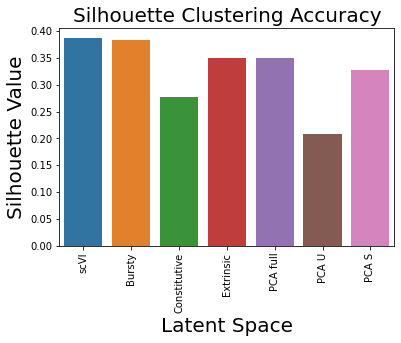

In [13]:
df_plot = pd.DataFrame(ss_dict).melt()
sns.barplot(data = df_plot,x = 'variable', y ='value')
plt.title('Silhouette Clustering Accuracy',fontsize=fs)
plt.ylabel('Silhouette Value',fontsize=fs)
plt.xlabel('Latent Space',fontsize=fs)
plt.xticks(rotation = 90)
plt.savefig(f'../../results/{name}_figs/silhouette_{index}.png',bbox_inches='tight');

In [14]:
print('SCVI')
print(ss_dict['scVI'])
print('BIVI')
print(ss_dict['Bursty'])

SCVI
[0.3867039]
BIVI
[0.38295755]


In [16]:
def l2_norm(x,y):
    
    a = (x-y)**2
    l2 = np.sqrt(np.sum(a))
    
    return(l2)

def get_intra_cluster_distances(X,cluster_assignments,return_all = False):
    ''' Get distance to cluster mean for each cell.
    -----
    params:
    latent_spaces : np array, size samples x features
    
    cluster_assignments : np array or list, size samples
    
    return_all : return distance to mean of cluster for ALL cells, default FALSE
    
    (if FALSE, returns AVERAGE distance to mean for each cluster assignment)
    -----
    
    returns:
    
    av_distance_to_mean : size n_clusters
    
    cluster_var : variance in av_distance_to_mean, size n_clusters
    
    if return_all == TRUE , also returns distances_to_mean : size # samples
    '''
    
    # declare array to hold all distances
    all_distances = np.zeros(X.shape[0])
    
    # declare array to hold average distances per cluster
    cluster_assignments = np.array(cluster_assignments)
    unique_clusters = np.unique(cluster_assignments)
    
    cluster_distances = np.zeros(len(unique_clusters))
    
    # declare array to hold average variances per cluster
    cluster_variances = np.zeros(len(unique_clusters))
    
    # how many cells have we calculated distances for? 
    cells_finished = 0
    
    # now go through each cluster and calculate distance between mean of that cluster and the vector
    for i,cluster in enumerate(unique_clusters):
        
        # subset to get samples in specific cluster
        X_subset = X[cluster_assignments == cluster]
        
        # take average across all samples in the cluster of the feature values
        cluster_mean = np.mean(X_subset,axis=0)
    
        # find the distance between samples in X_subset and the cluster mean
        distances_ = np.array([l2_norm(vec,cluster_mean) for vec in X_subset])
        
        # append or add distances to distance array
        all_distances[cells_finished : (cells_finished+X_subset.shape[0])] = distances_
        cells_finished += X_subset.shape[0]
        
        # average cluster distance
        cluster_distances[i] = np.mean(distances_)
        
        # variances
        cluster_variances[i] = np.var(distances_)
    
    cluster_variances = cluster_variances[cluster_variances != 0]
    cluster_distances = cluster_distances[cluster_distances != 0]
    all_distances = all_distances[all_distances != 0]
        
    if return_all == True:
        return(cluster_distances,cluster_variances,all_distances)
    
    else:
        return(cluster_distances,cluster_variances)

In [17]:
def get_inter_cluster_distances(X,cluster_assignments):
    ''' Gets distances between all cluster means. 
    --------
    params:
    X : size samples by features
    cluster assignments: clusters of samples in X
    
    -------
    returns:
    inter_cluster_distances : matrix size cluster by cluster of distances between each cluster
    '''
        
        
    cluster_assignments = np.array(cluster_assignments)
    unique_clusters = np.unique(cluster_assignments)
    
    # array to hold mean vectors for each cluster
    cluster_means = np.ones((len(unique_clusters),X.shape[1]))
    
    # array to hold inter cluster distances
    inter_cluster_distances = np.ones((len(unique_clusters),len(unique_clusters)))
    
     # calculate each cluster mean
    for i,cluster in enumerate(unique_clusters):
        
        # subset to get samples in specific cluster
        X_subset = X[cluster_assignments == cluster]
        
        # take average across all samples in the cluster of the feature values
        cluster_mean = np.mean(X_subset,axis=0)
        cluster_means[i,:] = cluster_mean
    
    for i in range(len(unique_clusters)):
        
        for j in range(len(unique_clusters)):
            
            inter_cluster_distances[i,j] = l2_norm(cluster_means[i],cluster_means[j])
            
    return(inter_cluster_distances)
                            
                            
        
        

--------

# Plot inter and intra-cluster distances for different setups

In [18]:
# # define latent spaces to compare

# extract the desired # pca components
num_pca = 10
x_pca_full = pca_full[:,:10]
x_pca_u = pca_u[:,:10]
x_pca_s = pca_s[:,:10]

# create a dictionary with the latent spaces 
X_latent = {}

for setup in results_dict.keys():
    X_latent[setup.split('-')[0]] = results_dict[setup]['X_10'][index_]

X_latent['PCA full'] = x_pca_full
X_latent['PCA U'] = x_pca_u
X_latent['PCA S'] = x_pca_s
    
    
# define dictionary of distances for each model
distance_dict = {ls : {} for ls in X_latent.keys()}
distance_dict_plot = {ls : {} for ls in X_latent.keys()}

In [19]:
for setup in X_latent.keys():
    
    cluster_distances,cluster_variances = get_intra_cluster_distances(X_latent[setup],cluster_assignments)
    inter_cluster_matrix = get_inter_cluster_distances(X_latent[setup],cluster_assignments)
    distance_dict[setup]['Intra-Cluster Distance to Mean'] = cluster_distances
    distance_dict[setup]['Intra-Cluster Variance'] = cluster_variances
    distance_dict[setup]['Inter-Cluster Distance between Means'] = inter_cluster_matrix
    distance_dict[setup]['Fano Factor'] = cluster_variances/cluster_distances 

    
    distance_dict_plot[setup]['Average Intra-Cluster Distance'] = np.mean(cluster_distances)
    distance_dict_plot[setup]['Average Intra-Cluster Variance'] = np.mean(cluster_variances)
    distance_dict_plot[setup]['Average Inter-Cluster Distance'] = np.mean(inter_cluster_matrix[inter_cluster_matrix != 0])
    distance_dict_plot[setup]['Average Fano Factor'] = np.mean(cluster_variances/cluster_distances)

In [20]:
# should I be dividing by some metric of overall norm ? it could be that the inter cluster is large but so is intra?
# average cluster inter cluster distance / average intra cluster distance -- want to be large ??? or something idk
distance_df = pd.DataFrame(distance_dict_plot).transpose

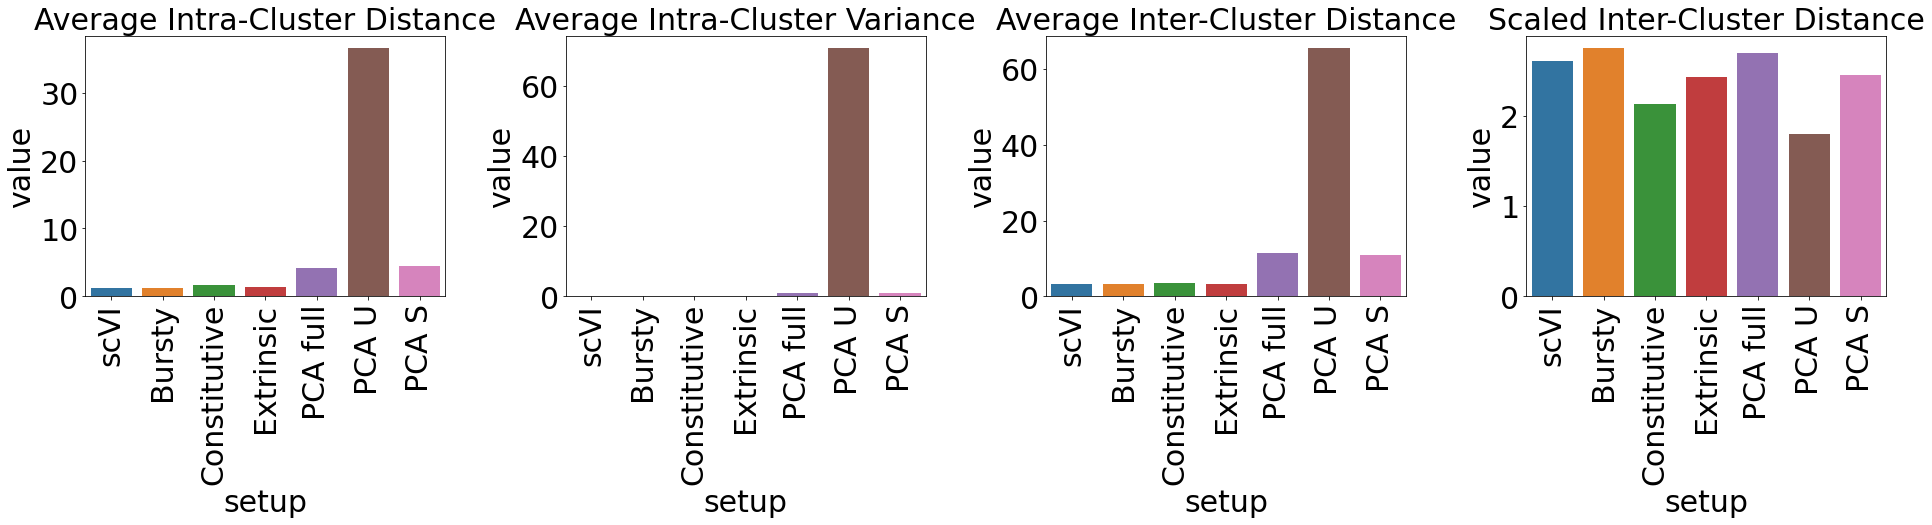

In [25]:
metrics = ['Average Intra-Cluster Distance',
           'Average Intra-Cluster Variance',
           'Average Inter-Cluster Distance']



fig,axes = plt.subplots(1,4,figsize = (27,8))
fs = 30
for i,metric in enumerate(metrics):
    
    dict_plot = {}
    ax = axes[i]
    setups = list(X_latent.keys())
    metric_list = [distance_dict_plot[setup][metric] for setup in setups]
    dict_plot['setup'] = setups
    dict_plot['metric'] = metric_list
    df_plot = pd.DataFrame(dict_plot)
    sns.barplot(ax = ax, data = df_plot, x = 'setup', y ='metric')
    ax.set_title(f'{metric}',fontsize = fs)
    ax.set_ylabel(f'value',fontsize=fs)
    #plt.xlabel('Latent Space Method')
    ax.set_xticklabels(labels = setups, rotation = 90)

ax= axes[i+1]
setups = list(X_latent.keys())
metric_list = [distance_dict_plot[setup]['Average Inter-Cluster Distance']/distance_dict_plot[setup]['Average Intra-Cluster Distance']
               for setup in setups]
dict_plot['setup'] = setups
dict_plot['metric'] = metric_list
df_plot = pd.DataFrame(dict_plot)
sns.barplot(ax = ax, data = df_plot,x = 'setup', y ='metric')
ax.set_title(f'Scaled Inter-Cluster Distance',fontsize = fs)
ax.set_ylabel(f'value',fontsize=fs)
ax.set_xticklabels(labels = setups, rotation = 90, fontsize = fs)
    
plt.tight_layout()
plt.savefig(f'../../results/{name}_figs/clustering_metrics_{index}.png',bbox_inches='tight');


In [26]:
metric = 'Scaled Inter-Cluster Distance'
print('SCVI')
print(distance_dict_plot['scVI']['Average Inter-Cluster Distance']/distance_dict_plot['scVI']['Average Intra-Cluster Distance'])
print('BIVI')
print(distance_dict_plot['Bursty']['Average Inter-Cluster Distance']/distance_dict_plot['Bursty']['Average Intra-Cluster Distance'])

SCVI
2.5999679210758053
BIVI
2.7472786364322244
